In [7]:
from google.colab import files
uploaded = files.upload()

Saving vehicles_clean.csv to vehicles_clean.csv


In [4]:
# Import necessary libraries
import sqlite3
import pandas as pd
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# Connect to the SQLite database
# conn = sqlite3.connect('used_cars.db')

In [ ]:
# query = "SELECT * FROM used_cars"
# cars_df = pd.read_sql(query, conn)

In [8]:
import io
cars_df = pd.read_csv(io.BytesIO(uploaded['vehicles_clean.csv']))
# Dataset is now stored in a Pandas Dataframe

In [9]:
# Load the data into a Pandas DataFrame
# cars_df = pd.read_csv(
#     "data/vehicles_clean.csv")

# Display sample data
cars_df.tail(10)

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,posting_date
80160,24995,2014,gmc,good,8 cylinders,gas,128722.0,clean,automatic,4wd,full-size,truck,white,wy,2021-04-07
80161,23495,2015,ford,like new,8 cylinders,gas,146795.0,clean,automatic,4wd,full-size,truck,black,wy,2021-04-07
80162,12995,2016,chevrolet,like new,4 cylinders,gas,61127.0,clean,automatic,fwd,compact,sedan,silver,wy,2021-04-07
80163,32999,2014,ford,excellent,8 cylinders,diesel,154642.0,clean,automatic,4wd,full-size,pickup,brown,wy,2021-04-07
80164,15999,2018,chevrolet,excellent,4 cylinders,gas,36465.0,clean,automatic,fwd,mid-size,sedan,black,wy,2021-04-07
80165,18000,2005,chevrolet,excellent,8 cylinders,gas,130000.0,lien,automatic,4wd,full-size,truck,blue,wy,2021-04-06
80166,18000,1990,jeep,good,8 cylinders,gas,114400.0,clean,automatic,4wd,full-size,SUV,black,wy,2021-04-06
80167,9800,1985,nissan,like new,6 cylinders,gas,115000.0,clean,automatic,rwd,sub-compact,hatchback,red,wy,2021-04-05
80168,6800,1997,jaguar,good,8 cylinders,gas,69550.0,clean,automatic,rwd,compact,convertible,white,wy,2021-04-05
80169,0,2018,ram,excellent,6 cylinders,diesel,20492.0,clean,automatic,4wd,full-size,truck,white,wy,2021-04-05


In [10]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80170 entries, 0 to 80169
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         80170 non-null  int64  
 1   year          80170 non-null  int64  
 2   manufacturer  80170 non-null  object 
 3   condition     80170 non-null  object 
 4   cylinders     80170 non-null  object 
 5   fuel          80170 non-null  object 
 6   odometer      80170 non-null  float64
 7   title_status  80170 non-null  object 
 8   transmission  80170 non-null  object 
 9   drive         80170 non-null  object 
 10  size          80170 non-null  object 
 11  type          80170 non-null  object 
 12  paint_color   80170 non-null  object 
 13  state         80170 non-null  object 
 14  posting_date  80170 non-null  object 
dtypes: float64(1), int64(2), object(12)
memory usage: 9.2+ MB


In [11]:
# Starting with the recommender via filtering first.
# Designating weights for features (WE CAN ADJUST THESE as we see fit)
weights = {
    'price': 3,
    'year': 3,
    'manufacturer': 1,
    'condition': 2,
    'odometer': 2,
    'size': 2,
    'type': 2,
    'paint_color': 2
}

In [12]:
# Determine "distance" from the user's selected features. Cars with the smallest
# distance to the user's selections are recommended.
# WE NEED TO DETERMINE FINAL SELECTION OPTIONS
# ['price', 'year', 'manufacturer', 'condition', 'odometer', 'size', 'type', 'paint_color']

def recommend_cars(user_choices, state, top_n=5):
    # Filter by state first
    df_state = cars_df[cars_df['state'] == state]

    distance = pd.Series([0] * len(df_state), index=df_state.index)

    for feature, value in user_choices.items():
        if feature in ['price', 'year', 'odometer']:
            print(f"Processing numeric feature: {feature} with value: {value}")
            distance += weights[feature] * abs(df_state[feature] - value)
        else:
            print(f"Processing non-numeric feature: {feature} with value: {value}")
            distance += weights[feature] * (df_state[feature] != value).astype(int)

    # Get the indices of the cars with the smallest "distances"
    recommended_indices = distance.nsmallest(top_n).index

    return df_state.loc[recommended_indices]


In [13]:
# Example of user selections
# user_input = {
#     'price': 15000,
#     'year': 2015,
#     'manufacturer': 'ford',
#     'condition': 'excellent',
#     'odometer': 100000,
#     'size': 'mid-size',
#     'type': 'sedan'
# }


user_input = {
    'price': 15000,
    'year': 2015,
    'odometer': 100000
}
state = 'ca'

print(recommend_cars(user_input, state))


Processing numeric feature: price with value: 15000
Processing numeric feature: year with value: 2015
Processing numeric feature: odometer with value: 100000
      price  year manufacturer  condition    cylinders fuel  odometer  \
5047  15000  2005        dodge       good  6 cylinders  gas  100090.0   
7308  14900  2006      lincoln       good  8 cylinders  gas  100300.0   
9425  14900  2006      lincoln  excellent  8 cylinders  gas  100300.0   
9747  14900  2006      lincoln  excellent  8 cylinders  gas  100300.0   
5365  14900  2006      lincoln  excellent  8 cylinders  gas  100500.0   

     title_status transmission drive       size      type paint_color state  \
5047        clean    automatic   fwd   mid-size  mini-van        blue    ca   
7308        clean    automatic   4wd  full-size    pickup       black    ca   
9425        clean    automatic   4wd  full-size    pickup       black    ca   
9747        clean    automatic   4wd  full-size    pickup       black    ca   
5365    

In [14]:
# ML Recommender with unsupervised learning
# One-hot encode the non-numerical features
encoded_cars_df = pd.get_dummies(cars_df, columns=[
    'manufacturer', 'condition', 'cylinders', 'fuel',
    'title_status', 'transmission', 'drive', 'size',
    'type', 'paint_color', 'state'
])

In [15]:
# Drop the 'posting_date' column
encoded_cars_df = encoded_cars_df.drop(columns=['posting_date'])

# Scale the features
scaler = StandardScaler()

scaled_cars_df = pd.DataFrame(scaler.fit_transform(encoded_cars_df), columns=encoded_cars_df.columns)

In [ ]:
scaled_cars_df.shape

(80170, 155)

In [16]:
# Find the best value for k
# Create a list with the number of k-values from 1 to 11
k = list(range(1, 11))

In [17]:
# THIS IS WHERE THE KERNEL DIES
# Too much for jupyter notebook (need to use google colab)
# Or, we can try simplifying our df to more integers and less objects

# Create an empty list to store the inertia values
inertia = []

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `scaled_cars_df`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters=i, random_state=0)
    k_model.fit(scaled_cars_df)
    inertia.append(k_model.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

In [18]:
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k, "inertia": inertia}


# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Curve   [k]   (inertia)
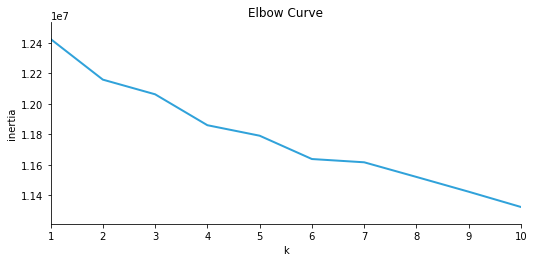

In [23]:
# Plot a line chart with all the inertia values computed with
# the different values of k to visually identify the optimal value for k.
import holoviews as hv

hv.extension('matplotlib')

og_elbow = df_elbow.hvplot.line(
    x="k",
    y="inertia",
    title="Elbow Curve",
    xticks=k
)

og_elbow

In [20]:
df_elbow

,k,inertia
0,1,1.242635e+07
1,2,1.215883e+07
2,3,1.206226e+07
3,4,1.185873e+07
4,5,1.178959e+07
5,6,1.163604e+07
6,7,1.161459e+07
7,8,1.151811e+07
8,9,1.142083e+07
9,10,1.132021e+07


In [ ]:
# Cluster Cryptocurrencies with K-means
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=?)

In [ ]:
# Fit the K-Means model using the scaled data
model.fit(scaled_cars_df)

In [ ]:
# Predict the clusters to group the cryptocurrencies using the scaled data
crypto_clusters = model.predict(scaled_cars_df)


# Print the resulting array of cluster values.
print(crypto_clusters)

In [ ]:
# Create a copy of the DataFrame
scaled_cars_df_predictions = scaled_cars_df.copy()

In [ ]:
# Add a new column to the DataFrame with the predicted clusters
scaled_cars_df_predictions["CryptoCluster"] = crypto_clusters


# Display sample data
scaled_cars_df_predictions.head()

In [ ]:
# Create a scatter plot using hvPlot by setting
# `x="X"` and `y="Y"`.
# Color the graph points with the labels found using K-Means and
# add the crypto name in the `hover_cols` parameter to identify
# the cryptocurrency represented by each data point.

k_means_plot = scaled_cars_df_predictions.hvplot.scatter(
    x="X",
    y="Y",
    by="CryptoCluster",
    hover_cols=["?"],
)

k_means_plot